# Unseen Categories Notebook

One problem often encountered with categorical features is the presence of 'unseen' or new categories that appear in queries after a model has been trained. This could be due to incomplete training data coverage or simply that a new category has been 'added' in the real world. 

With Hybrid Intelligence, you have the option to create a trained model that can handle unseen categories. This is achieved using Masking, which is a technique that involves treating unseen categories as a special **\__MASK__** category during both training and inference phases. This allows the model to generalize to unseen categories and make more reasonable predictions.

During training, the masking process involves replacing a portion of the training examples' categorical values with the **\__MASK__** category. By exposing the model to instances with the **\__MASK__** category, it learns to handle and generalize to unseen categories. In Hybrid Intelligence, you can control the proportions of training rows and categories to mask.

In this example, we will enable handling of unseen categories for the categorical feature `Occupation` in the Adult Income dataset.

# Check Environment Variables
Before installing Hybrid Intelligence in the notebook you need to set these Environment Variables externally as described in the User Guide https://docs.umnai.com/set-up-your-environment. 
This section checks that the environment variables have been set correctly and throws an error if not.

In [1]:
import os

umnai_env_vars = {
    'UMNAI_CLIENT_ID',
    'UMNAI_CLIENT_SECRET',
    'PIP_EXTRA_INDEX_URL',
}

if os.environ.get('DATABRICKS_RUNTIME_VERSION') is not None:
    umnai_env_vars.update({
        'DATABRICKS_HOST',
        'DATABRICKS_TOKEN',
    })

if not umnai_env_vars.issubset(os.environ.keys()):
    raise ValueError(
        'UMNAI environment variables not set correctly. They need to be set before using the Umnai library.'
    )

# Install Hybrid Intelligence
Next we install the UMNAI Platform.

In [2]:
%pip install umnai-platform --quiet


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


# Set Workspace Paths According to Your Environment
Now we will set the workspace path and the experiment path automatically. They will be set to a local path if you are using a local machine environment or to a Databricks path if you are using a Databricks environment.

## Install Databricks SDK

This checks if you are running on Databricks and installs their SDK if you are.

In [3]:
import os
if os.environ.get('DATABRICKS_RUNTIME_VERSION') is not None:
    %pip install databricks-sdk --quiet

If you are on Databricks, you can select whether you would like the workspace to be created in the shared area (available to all users in your account) or in your personal user account area. You can ignore this if you are running on a local environment.

In [4]:
# Set to 1 if you want to use shared or 0 to use personal user account area.
USE_SHARED_WORKSPACE = 1 

## Set Paths
Next the workspace and experiment paths are set automatically.

In [5]:
import os

EXP_NAME = 'unseencategories_adult_income'
if os.environ.get('DATABRICKS_RUNTIME_VERSION') is not None:
    from databricks.sdk import WorkspaceClient
    w = WorkspaceClient()

    # # For a Databricks Environment
    WS_PATH = '/dbfs/FileStore/workspaces/'+EXP_NAME
    if USE_SHARED_WORKSPACE:
        EXP_PREFIX = f'/Shared/experiments/'
    else:
        USERNAME = dbutils.notebook.entry_point.getDbutils().notebook().getContext().userName().get()
        EXP_PREFIX = f'/Users/{USERNAME}/experiments/'
    w.workspace.mkdirs(EXP_PREFIX)
    EXP_PATH = EXP_PREFIX + EXP_NAME
else:
    # For a Local Machine Environment
    WS_PATH = 'resources/workspaces/'+EXP_NAME
    EXP_PATH = EXP_NAME

# Import and Prepare Dataset
Import the dataset to a Pandas DataFrame and the clean data in preparation for onboarding into Hybrid Intelligence.

In [6]:
import pandas as pd
import numpy as np

# Import Adult Income Dataset to pandas dataframe: 
# This dataset can be downloaded from https://archive.ics.uci.edu/dataset/2/adult 
column_names = ["Age", "WorkClass", "fnlwgt", "Education", "EducationNum", "MaritalStatus", "Occupation", "Relationship", "Race", "Gender", "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"]
dataset_df = pd.read_csv('https://raw.githubusercontent.com/umnaibase/umnai-examples/main/data/adult.data', names = column_names)

# Data Preparation:
dataset_df = dataset_df.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)    # Remove whitespaces
dataset_df["Income"] = np.where((dataset_df["Income"] == '<=50K'), 0, 1)                # Replace Target values with [0,1]
dataset_df["Occupation"] = dataset_df["Occupation"].replace('?',np.nan)                 # Replace '?' in Occupation with NULL
dataset_df.tail(5)

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,1


# Create or Open a Hybrid Intelligence Workspace
Workspaces are used by the Hybrid Intelligence framework to organize your data and models together in one place.

In [7]:
from umnai.workspaces.context import Workspace

# Open a workspace
ws = Workspace.open(
    path = WS_PATH,
    experiment = EXP_PATH
)

ws # Prints workspace details to confirm created/opened

# Onboard Hybrid Intelligence Dataset

Onboard the Pandas DataFrame into a Hybrid Intelligence dataset.

## Enable Handle Unseen Categories for `Occupation`

When you onboard a dataset using `from_pandas()` or `from_spark()`, you can enable unseen category handling either globally (for all categorical features) or for specific categorical features using the `handle_unseen_categories` parameter as follows:
- To enable unseen category handling for all categorical features, you should set `handle_unseen_categories` to `True`
- To enable unseen category handling for specific categorical features, you should pass the desired list of categorical features to the `handle_unseen_categories` parameter

In this case, we will set the feature `Occupation` to handle unseen categories.

In [8]:
from umnai.data.datasets import Dataset
from umnai.data.enums import PredictionType

dataset = Dataset.from_pandas(
    dataset_df,
    prediction_type=PredictionType.CLASSIFICATION,
    features=list(dataset_df.drop(['Income'], axis=1).columns),    # All columns except 'Income' are features
    targets=['Income'],
    handle_unseen_categories=['Occupation']     # Handle Unseen Categories for Feature Occupation
)

dataset # Prints dataset details to confirm created/opened

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/01/17 11:47:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting Spark log level to "WARN".


[DatasetInitialization] - MLFLOW Run ID: 3ccabc7eed5745a09eeb14302b129efe:   0%|          | 0/42 [00:00<?, ?it…

/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3548: UmnaiWarning: Categorical column "Occupation" contains null values. MASKing has been enabled.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


/usr/local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3548: UmnaiWarning: Dropped 1843 train data rows which contain empty values.
  Hint: Impute train data before fitting.


INFO:tensorflow:Assets written to: /opt/atlassian/pipelines/agent/build/demo-notebooks/resources/workspaces/unseencategories_adult_income/preprocessing/dataset_name=Dataset_5bda5cd9/assets


Dataset(id=ab53bd46-5348-4839-87c1-9d951244ec23; name=Dataset_5bda5cd9; is_named=False; workspace_id=None)

# 1D-Histogram data for `Occupation`

If you look at the 1D Histogram for `Occupation` you can see **\__MASK__** category.

In [9]:
dataset.metadata.histogram_1d["Occupation"].to_pandas()

,dataset_id,field,field_type,is_categorical,token,bin_index,is_infrequent,is_masked_token,frequency,frequency_fraction,target_min,target_max,target_sum,target_mean,target_var
0,ab53bd465348483987c19d951244ec23,Occupation,FEATURE,True,Adm-clerical,0,False,False,3770,0.098885,[0],[1],[507],[0.13448275862068965],[0.11639714625445897]
1,ab53bd465348483987c19d951244ec23,Occupation,FEATURE,True,Armed-Forces,0,False,False,9,0.000236,[0],[1],[1],[0.1111111111111111],[0.09876543209876543]
2,ab53bd465348483987c19d951244ec23,Occupation,FEATURE,True,Craft-repair,0,False,False,4099,0.107515,[0],[1],[929],[0.22664064405952672],[0.17527466251980964]
3,ab53bd465348483987c19d951244ec23,Occupation,FEATURE,True,Exec-managerial,0,False,False,4066,0.106649,[0],[1],[1968],[0.4840137727496311],[0.24974444053829956]
4,ab53bd465348483987c19d951244ec23,Occupation,FEATURE,True,Farming-fishing,0,False,False,994,0.026072,[0],[1],[115],[0.11569416498993963],[0.10230902517722026]
5,ab53bd465348483987c19d951244ec23,Occupation,FEATURE,True,Handlers-cleaners,0,False,False,1370,0.035934,[0],[1],[86],[0.06277372262773723],[0.05883318237519314]
6,ab53bd465348483987c19d951244ec23,Occupation,FEATURE,True,Machine-op-inspct,0,False,False,2002,0.052511,[0],[1],[250],[0.12487512487512488],[0.10928132806254684]
7,ab53bd465348483987c19d951244ec23,Occupation,FEATURE,True,Other-service,0,False,False,3295,0.086426,[0],[1],[137],[0.04157814871016692],[0.03984940626000216]
8,ab53bd465348483987c19d951244ec23,Occupation,FEATURE,True,Priv-house-serv,0,False,False,149,0.003908,[0],[1],[1],[0.006711409395973154],[0.006666366379892798]
9,ab53bd465348483987c19d951244ec23,Occupation,FEATURE,True,Prof-specialty,0,False,False,4140,0.108590,[0],[1],[1859],[0.44903381642512075],[0.2474024481318117]


# Induce a Hybrid Intelligence Model

You do not need to make any alterations to the standard procedure to induce a model from a dataset that includes unseen category handling.

Pre-induced models are available in the notebook workspace on Github and may be downloaded and saved locally. Using Pre-induced models will speed up the execution of the notebook.

If `LOAD_PREINDUCED_MODEL` is set to `1` (default), the notebook will look for and load the pre-induced model with `ESM_ID`. Otherwise, if set to `0` or the pre-induced model is not found, a new model will be induced and saved to the workspace.

In [10]:
# Set this variable to '1' to load a pre-induced model, otherwise set to '0' to re-induce a new model from the dataset
LOAD_PREINDUCED_MODEL = 1

# Model ID
ESM_ID='Dataset_bd5462be_231d4ee0f69147d8be113cb18b1b788f'

#### Load or Induce the Model

In [11]:
from umnai.esm.model import ESM
from umnai.induction.inducer import ModelInducer

# Check if a saved model with the ESM_ID exists. If it exists load it, otherwise induce a new model, save it and print the model and run IDs
if (LOAD_PREINDUCED_MODEL == 1):
    try:    
        esm = ESM.from_workspace(id = ESM_ID)
        print('Pre-induced ESM loaded from workspace: ' + esm.id)
    except OSError:
        print("No model found in workspace.")
        LOAD_PREINDUCED_MODEL = 0

if (LOAD_PREINDUCED_MODEL == 0):
    print("Inducing a new model - this may take some time.")
    # Induce a simple model quickly using fast execution parameters
    model_inducer = ModelInducer(
        max_interactions=3,
        max_interaction_degree=2,
        max_polynomial_degree=2,
        trials=2,
        estimators=2,
        batch_size=512,
        iterations=2,
    )

    # # Induce a more realistic model using default Induction parameters:
    # model_inducer = ModelInducer()

    # Create an ESM using Induction
    esm = model_inducer.induce(dataset)

    # Save the ESM to your workspace
    esm.save_to_workspace()

    # Note ESM ID and MLFLow Run ID
    print("ESM ID: ", esm.id)
    print("MLflow Run ID: ", esm.producer_run_id)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Pre-induced ESM loaded from workspace: Dataset_bd5462be_231d4ee0f69147d8be113cb18b1b788f


# Inference: Query a Model 
When you query a Hybrid Intelligence model you get predictions together with explanations in real-time.

## Create a Query with an Unseen Category

To test unseen category handling we will create a query with an unseen category for the feature `Occupation`.

In [12]:
from umnai.explanations.local import Query
import pandas as pd

query = Query({
    'Age': [39],
    'WorkClass': ['State-gov'],
    'fnlwgt': [77516],
    'Education': ['Bachelors'],
    'EducationNum': [13],
    'MaritalStatus': ['Never-married'],
    'Occupation': ['Data-Scientist'],    # New unseen category for feature Occupation
    'Relationship': ['Not-in-family'],
    'Race': ['White'],
    'Gender': ['Male'],
    'CapitalGain': [2174],
    'CapitalLoss': [0],
    'HoursPerWeek': [40],
    'NativeCountry': ['United-States']
})

### Instantiate a Local Explainer
Create a LocalExplainer to define the ESM you want to query. The local explainer lets you extract query explanations and predictions in real-time.

In [13]:
from umnai.explanations.local import LocalExplainer

# Instantiate a LocalExplainer:
local_explainer = LocalExplainer(esm)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


## Query Result with Unseen Categories

When you are viewing a query result, the attributions from the unseen category will be in terms of the original feature and the **\__MASK__** category.

### Submit the Query
Then you should pass the Query object to the local explainer instance. This will return a QueryResult that includes the prediction and the query explanation.

In [14]:
# Query the model:
query_result = local_explainer(query)

#  Display the Query Result together with the explanation
query_result.data

/usr/local/lib/python3.10/site-packages/keras/src/engine/base_layer.py:1149: UmnaiWarning: The column Occupation has unseen categorical values. You may ignore this warning if you are intentionally inputting new categories.


{'query_input': {'Age': array([39]),
  'WorkClass': array(['State-gov'], dtype=object),
  'fnlwgt': array([77516]),
  'Education': array(['Bachelors'], dtype=object),
  'EducationNum': array([13]),
  'MaritalStatus': array(['Never-married'], dtype=object),
  'Occupation': array(['Data-Scientist'], dtype=object),
  'Relationship': array(['Not-in-family'], dtype=object),
  'Race': array(['White'], dtype=object),
  'Gender': array(['Male'], dtype=object),
  'CapitalGain': array([2174]),
  'CapitalLoss': array([0]),
  'HoursPerWeek': array([40]),
  'NativeCountry': array(['United-States'], dtype=object)},
 'scenario_id': None,
 'context_id': None,
 'query_row_hash': array([98104243068331863421568926497357824990], dtype=object),
 'query_created_time': datetime.datetime(2024, 1, 17, 11, 48, 26, tzinfo=<UTC>),
 'model_id': 'Dataset_bd5462be_231d4ee0f69147d8be113cb18b1b788f',
 'model_intercept': -0.4391311,
 'dataset_id': '299fdb39b5aa46aaab662b6a4029b27d',
 'run_id': None,
 'run_created_time'

# Explore a Model with Unseen Categories

When you are exploring a model, the unseen category feature and any interaction modules should include partitions that have rules based on the **\__MASK__** category.

## ModelSummaryView

In [15]:
from umnai.views.model_summary import ModelSummaryView

model_summary_view = ModelSummaryView(esm=esm)
model_summary_view.data

{'model_id': 'Dataset_bd5462be_231d4ee0f69147d8be113cb18b1b788f',
 'model_name': 'esm',
 'model_title': None,
 'model_created': datetime.datetime(2024, 1, 16, 15, 35, 11, tzinfo=<UTC>),
 'model_last_trained': datetime.datetime(2024, 1, 16, 15, 35, 11, tzinfo=<UTC>),
 'model_uvc': '9743ca08c16f0246eeff048125d804275c9ef42a8988074a8f6982e1c6fdabb4',
 'model_intercept': -0.43913111090660095,
 'has_personal_individual_data': False,
 'has_reuse_restrictions': False,
 'model_doi': '',
 'model_copyright': '',
 'n_input_features': 14,
 'n_transformed_features': 108,
 'n_output_targets': 1,
 'features': ['Age',
  'WorkClass',
  'fnlwgt',
  'Education',
  'EducationNum',
  'MaritalStatus',
  'Occupation',
  'Relationship',
  'Race',
  'Gender',
  'CapitalGain',
  'CapitalLoss',
  'HoursPerWeek',
  'NativeCountry'],
 'targets': ['Income'],
 'n_modules': 15,
 'n_partitions': 23,
 'max_interaction_degree': 2,
 'model_interaction_count': 25,
 'max_width': 2,
 'max_depth': 4,
 'n_categorical_features'

## PartialDependencyView
When you create the Partial Dependency View for a feature module that has unseen category handling enabled, you will see the attributions from the **\__MASK__** category.

In [16]:
from umnai.views.partial_dependency import PartialDependencyView

# Select a module
selected_module = 'Occupation'

# Generate the view
partial_dependency_view = PartialDependencyView(esm=esm, module=selected_module, use_training_data=False)

# Display the results
partial_dependency_view.data

,input_feature.Occupation,attribution.Income,attribution_normalized.Income,module_partition_index,rule_id,condition_expr_friendly,attribution_delta.Income
0,Adm-clerical,-0.277356,-0.053493,0,a1e9b0164fec486f97ae838047a30017,FOR ALL,NaN
1,Armed-Forces,-0.240498,-0.046384,0,a1e9b0164fec486f97ae838047a30017,FOR ALL,0.036858
2,Craft-repair,-0.151968,-0.029310,0,a1e9b0164fec486f97ae838047a30017,FOR ALL,0.088530
3,Exec-managerial,0.451625,0.087104,0,a1e9b0164fec486f97ae838047a30017,FOR ALL,0.603593
4,Farming-fishing,-0.747080,-0.144088,0,a1e9b0164fec486f97ae838047a30017,FOR ALL,-1.198706
5,Handlers-cleaners,-0.664114,-0.128087,0,a1e9b0164fec486f97ae838047a30017,FOR ALL,0.082966
6,Machine-op-inspct,-0.457795,-0.088294,0,a1e9b0164fec486f97ae838047a30017,FOR ALL,0.206319
7,Other-service,-0.867854,-0.167382,0,a1e9b0164fec486f97ae838047a30017,FOR ALL,-0.410059
8,Priv-house-serv,-0.415844,-0.080203,0,a1e9b0164fec486f97ae838047a30017,FOR ALL,0.452010
9,Prof-specialty,0.264249,0.050965,0,a1e9b0164fec486f97ae838047a30017,FOR ALL,0.680093


### Sample PDP plot for `Occupation`
You can use matplotlib or any other vizualisation tool to plot the Attribution as a function of the input value.

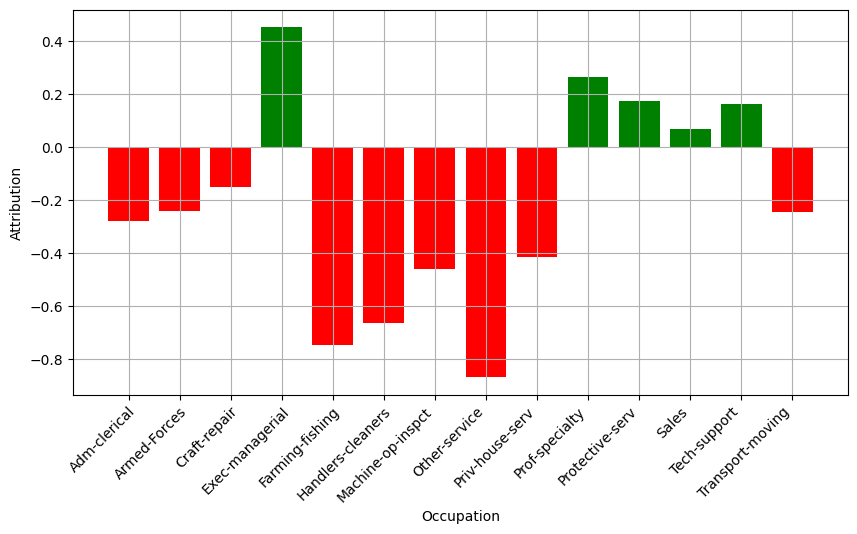

In [17]:
import matplotlib.pyplot as plt

colors = ['g' if x >= 0 else 'r' for x in partial_dependency_view.data['attribution.Income']]
plt.figure(figsize=(10, 5))
plt.xlabel(selected_module)
plt.xticks(rotation = 45, ha = 'right', rotation_mode='anchor')
plt.ylabel("Attribution")
plt.grid(which='major', axis='both')
plt.bar(partial_dependency_view.data['input_feature.Occupation'], partial_dependency_view.data['attribution.Income'], color=colors)
plt.show()

# Explain a Query with an Unseen Category

When you create a Feature Attribution View or an Interaction Attribution View, you will see the attributions of the original feature and some expressions should include the **\__MASK__** category.

## FeatureAttributionView

In [18]:
from umnai.views.feature_attribution import FeatureAttributionView

# Create the view and display the data
feature_attribution_view = FeatureAttributionView(query_result)
feature_attribution_view.data

/usr/local/lib/python3.10/functools.py:981: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  val = self.func(instance)


,input_feature,feature_attribution,feature_attribution_absolute,feature_attribution_normalized,grouped_features,feature_input
0,MaritalStatus,-1.881544,1.881544,0.448161,None,Never-married
1,EducationNum,1.050435,1.050435,0.250201,None,13
2,Relationship,-0.298315,0.298315,0.071055,None,Not-in-family
3,Age,0.265949,0.265949,0.063346,None,39
4,Education,0.220088,0.220088,0.052422,None,Bachelors
5,CapitalGain,0.172568,0.172568,0.041104,None,2174
6,CapitalLoss,-0.066844,0.066844,0.015921,None,0
7,WorkClass,-0.060429,0.060429,0.014393,None,State-gov
8,HoursPerWeek,-0.056369,0.056369,0.013426,None,40
9,fnlwgt,-0.034018,0.034018,0.008103,None,77516


## InteractionAttributionView

In [19]:
from umnai.views.interaction_attribution import InteractionAttributionView

# Create the view and display the data
interaction_attribution_view = InteractionAttributionView(query_result)
interaction_attribution_view.data

/usr/local/lib/python3.10/functools.py:981: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  val = self.func(instance)


,module_id,module_index,module_name,module_partition_index,global_partition_index,rule_id,output_target_index,total_attribution,total_attribution_normalized,input_feature_0,grouped_features_0,input_feature_1,grouped_features_1,feature_attribution_0,feature_attribution_1,feature_input_0,feature_input_1,condition_expr_friendly,summarized_then_expr
0,Dataset_bd5462be_231d4ee0f69147d8be113cb18b1b7...,8,MaritalStatus,0,13,ea7ba373334447ea8b9f678a7730b6b1,0,-0.582203,0.211247,MaritalStatus,None,None,None,-0.582203,NaN,Never-married,NaN,"MaritalStatus ≠ ""Married-civ-spouse""",-0.558425366878510 - 0.0237775519490242*(Mari...
1,Dataset_bd5462be_231d4ee0f69147d8be113cb18b1b7...,14,EducationNum x MaritalStatus,0,21,59309620f4b94294a68041db743d9985,0,-0.578169,0.209784,MaritalStatus,None,EducationNum,None,-1.299342,0.721172,Never-married,13.0,"MaritalStatus ≠ ""Married-civ-spouse""",-0.561650335788727 + 0.00158497621305287*Educ...
2,Dataset_bd5462be_231d4ee0f69147d8be113cb18b1b7...,2,EducationNum,1,7,eaaf0e92a9df4ead8941173024830983,0,0.329263,0.119470,EducationNum,None,None,None,0.329263,NaN,13,NaN,EducationNum > 10.5,0.326419949531555 + 0.000144481775350869*Educ...
3,Dataset_bd5462be_231d4ee0f69147d8be113cb18b1b7...,12,Relationship,0,18,28e549216c3144e9b16945ece71bd3a5,0,-0.298315,0.108241,Relationship,None,None,None,-0.298315,NaN,Not-in-family,NaN,"Relationship ≠ ""Husband""",-0.523417353630066 + 0.225102543830872*(Relat...
4,Dataset_bd5462be_231d4ee0f69147d8be113cb18b1b7...,0,Age,2,2,ef4bd35045c44e2fa8a1385c5300794f,0,0.265949,0.096497,Age,None,None,None,0.265949,NaN,39,NaN,(Age > 38.5) and (Age ≤ 49.5),0.265525579452515 + 6.19233944121333e-8*Age**...
5,Dataset_bd5462be_231d4ee0f69147d8be113cb18b1b7...,6,Education,0,11,755f874b3add4741a72715525bf1d0fa,0,0.220088,0.079857,Education,None,None,None,0.220088,NaN,Bachelors,NaN,FOR ALL,-0.329586386680603 + 0.549674689769745*(Educa...
6,Dataset_bd5462be_231d4ee0f69147d8be113cb18b1b7...,3,CapitalGain,0,8,7188e9796f8f4a41a233bdd9bb171bea,0,0.172568,0.062615,CapitalGain,None,None,None,0.172568,NaN,2174,NaN,FOR ALL,-0.151474684476852 + 8.02511668229755e-11*Cap...
7,Dataset_bd5462be_231d4ee0f69147d8be113cb18b1b7...,4,CapitalLoss,0,9,41ecfcefce21425f9f1e844b119bf3bc,0,-0.066844,0.024254,CapitalLoss,None,None,None,-0.066844,NaN,0,NaN,FOR ALL,-0.0668435990810394
8,Dataset_bd5462be_231d4ee0f69147d8be113cb18b1b7...,13,WorkClass,0,20,9a30cafc6fb845b583c371a669183765,0,-0.060429,0.021926,WorkClass,None,None,None,-0.060429,NaN,State-gov,NaN,FOR ALL,-0.0267791002988815 - 0.0336498320102692*(Wor...
9,Dataset_bd5462be_231d4ee0f69147d8be113cb18b1b7...,5,HoursPerWeek,0,10,0cd8b6c0bdca46e1abd3c5205f716a0a,0,-0.056369,0.020453,HoursPerWeek,None,None,None,-0.056369,NaN,40,NaN,FOR ALL,-0.203672796487808 + 2.07236407732125e-5*Hour...
